In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.constants import h, c, k
import pandas as pd

cfl = pd.read_csv('LauraJuan/CFL.txt', sep = ';', header=None).to_numpy()
flash = pd.read_csv('LauraJuan/FlashCel.txt', sep = ';', header=None).to_numpy()
hgar = pd.read_csv('LauraJuan/HgAr.txt', sep = ';', header=None).to_numpy()
panta = pd.read_csv('LauraJuan/PantallaCel.txt', sep = ';', header=None).to_numpy()
esfera = pd.read_csv('LauraJuan/LamparaEsfera.Master.irradiance', sep = '\t', skiprows=14, skipfooter=1, header=None)[:-1].to_numpy()

# Paso 1: Cargar los datos medidos
# Reemplaza estas listas con tus datos medidos
longitud_onda = esfera[:,0]  # Longitud de onda en metros
intensidad = esfera[:,1]     # Intensidad medida

# Si tus datos están en nanómetros, conviértelos a metros
longitud_onda = longitud_onda * 1e-9  # Convertir nm a m
longitud_onda_pico_sin_ajuste = longitud_onda[np.argmax(intensidad)]

/tmp/ipykernel_22379/720893157.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  esfera = pd.read_csv('LauraJuan/LamparaEsfera.Master.irradiance', sep = '\t', skiprows=14, skipfooter=1, header=None)[:-1].to_numpy()


In [42]:
# Paso 3: Definir la función de la ley de Planck para el ajuste
def planck(λ, A, T):
    """
    Ley de radiación de Planck.

    Parámetros:
    λ : Longitud de onda en metros.
    A : Factor de escala (amplitud).
    T : Temperatura en Kelvin.

    Retorna:
    Intensidad espectral en unidades arbitrarias.
    """
    return (A / λ**5) * (1 / (np.exp(h * c / (λ * k * T)) - 1))

# Valores iniciales para el ajuste
A_inicial = np.max(intensidad) * longitud_onda_pico_sin_ajuste**5
T_inicial = 3100

In [43]:
# Paso 4: Ajustar el espectro medido usando la ley de Planck
parametros_iniciales = [A_inicial, T_inicial]
parametros_optimos, covarianza = curve_fit(planck, longitud_onda, intensidad, p0=parametros_iniciales)
A_optimo, T_optima = parametros_optimos


# Imprimimos la temperatura ajustada con su respectivo error
print(f"Temperatura ajustada con la ley de Planck: {T_optima:.2f} K ± {np.sqrt(np.diag(covarianza))[1]:.2f} K")

Temperatura ajustada con la ley de Planck: 2493.18 K ± 1.35 K


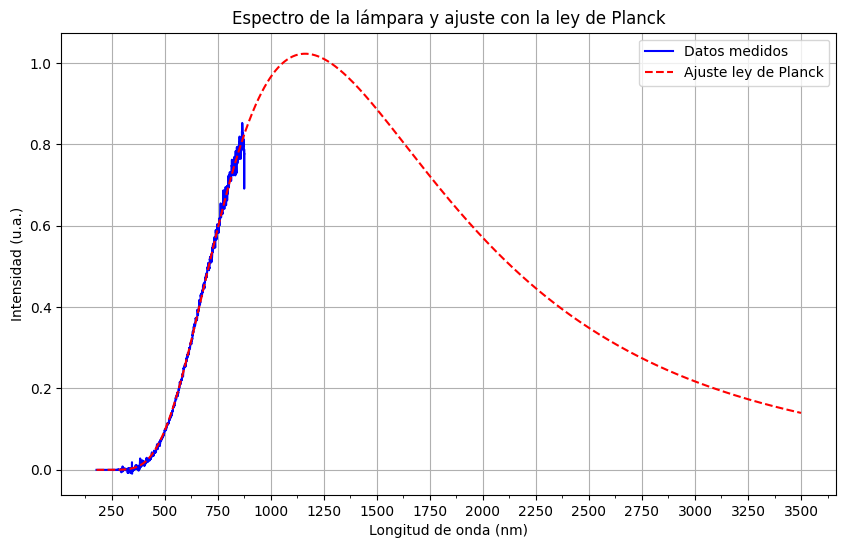

In [44]:
# Paso 6: Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(longitud_onda * 1e9, intensidad, 'b-', label='Datos medidos')
# Al ajuste le damos un arrary de longuitud de onda mas amplio, llegando hasta 2.5e-6
longitud_onda_ajuste = np.linspace(longitud_onda.min(), 3.5e-6, 1000)
intensidad_ajustada_p = planck(longitud_onda_ajuste, A_optimo, T_optima)
plt.plot(longitud_onda_ajuste * 1e9, intensidad_ajustada_p, 'r--', label='Ajuste ley de Planck')
plt.xlabel('Longitud de onda (nm)')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(250))
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(125))
plt.ylabel('Intensidad (u.a.)')
plt.title('Espectro de la lámpara y ajuste con la ley de Planck')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
# Paso 2: Encontrar el pico del espectro y calcular la temperatura con la ley de Wien
longitud_onda_pico = longitud_onda_ajuste[np.argmax(intensidad_ajustada_p)]
temperatura_wien = (2.897771955e-3) / longitud_onda_pico  # Constante de Wien en m·K
error_temperatura_wien =  (2.897771955e-3) / longitud_onda_pico**2 * 1e-11

print(f"Longitud de onda del pico: {longitud_onda_pico*1e9:.2f} nm ± {1e-11*1e9:.2f} nm")
print(f"Temperatura estimada con la ley de Wien: {temperatura_wien:.2f} K ± {error_temperatura_wien:.2f} K")

Longitud de onda del pico: 1163.00 nm ± 0.01 nm
Temperatura estimada con la ley de Wien: 2491.64 K ± 0.02 K


Número de intervalos (nbin): 11
Rango de intensidades: -0.01 a 0.85
Chi cuadrado: 0.84


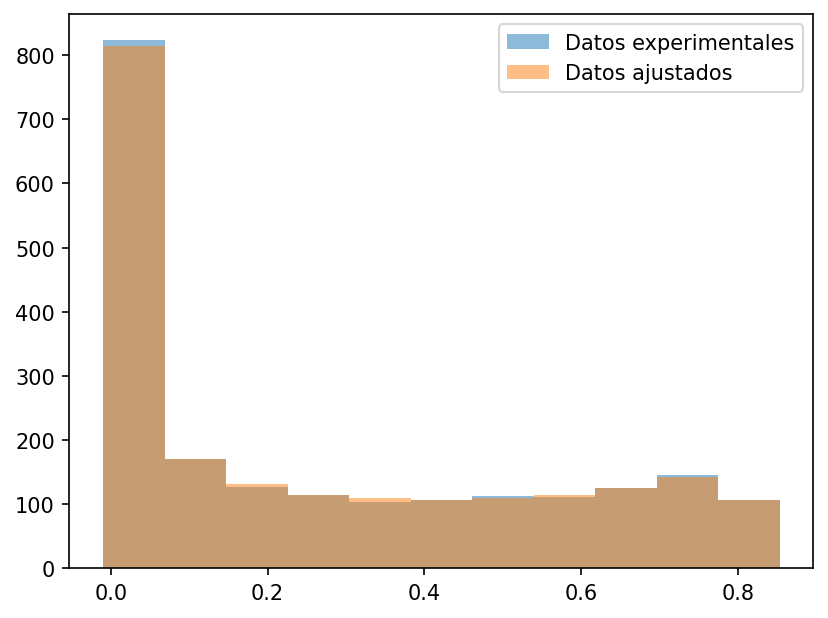

In [46]:
# Paso 5: Calcular el chi cuadrado utilizando histogramas y el criterio de Sturges

# Asignar intensidad y ajuste a variables más cortas
y = intensidad
intensidad_ajustada = planck(longitud_onda, A_optimo, T_optima)

# Definir el número de intervalos para el test de chi cuadrado usando el criterio de Sturges
nbin = int(1 + 3.322 * np.log10(len(y)))
print(f"Número de intervalos (nbin): {nbin}")

# Definir un rango mínimo y máximo común para los datos experimentales y ajustados
ymin = min(y.min(), intensidad_ajustada.min())
ymax = max(y.max(), intensidad_ajustada.max())
print(f"Rango de intensidades: {ymin:.2f} a {ymax:.2f}")

# Crear histogramas para los datos experimentales y ajustados
plt.figure(dpi=150)
n, bins, patches = plt.hist(y, bins=nbin, range=(ymin, ymax), alpha=0.5, label='Datos experimentales')
naj, bins_aj, patches_aj = plt.hist(intensidad_ajustada, bins=nbin, range=(ymin, ymax), alpha=0.5, label='Datos ajustados')
plt.legend()

# Definir la función para calcular chi cuadrado
def chi_sqr(dathistexp, dathistaj):
    # Evitar divisiones por cero
    mask = dathistaj > 0
    chi_sq = np.sum(((dathistexp[mask] - dathistaj[mask]) ** 2) / dathistaj[mask])
    return chi_sq

chi_cuadrado = chi_sqr(n, naj)
grados_libertad = nbin - 1 - len(parametros_optimos)
chi_cuadrado_reducido = chi_cuadrado / grados_libertad

print(f"Chi cuadrado: {chi_cuadrado:.2f}")

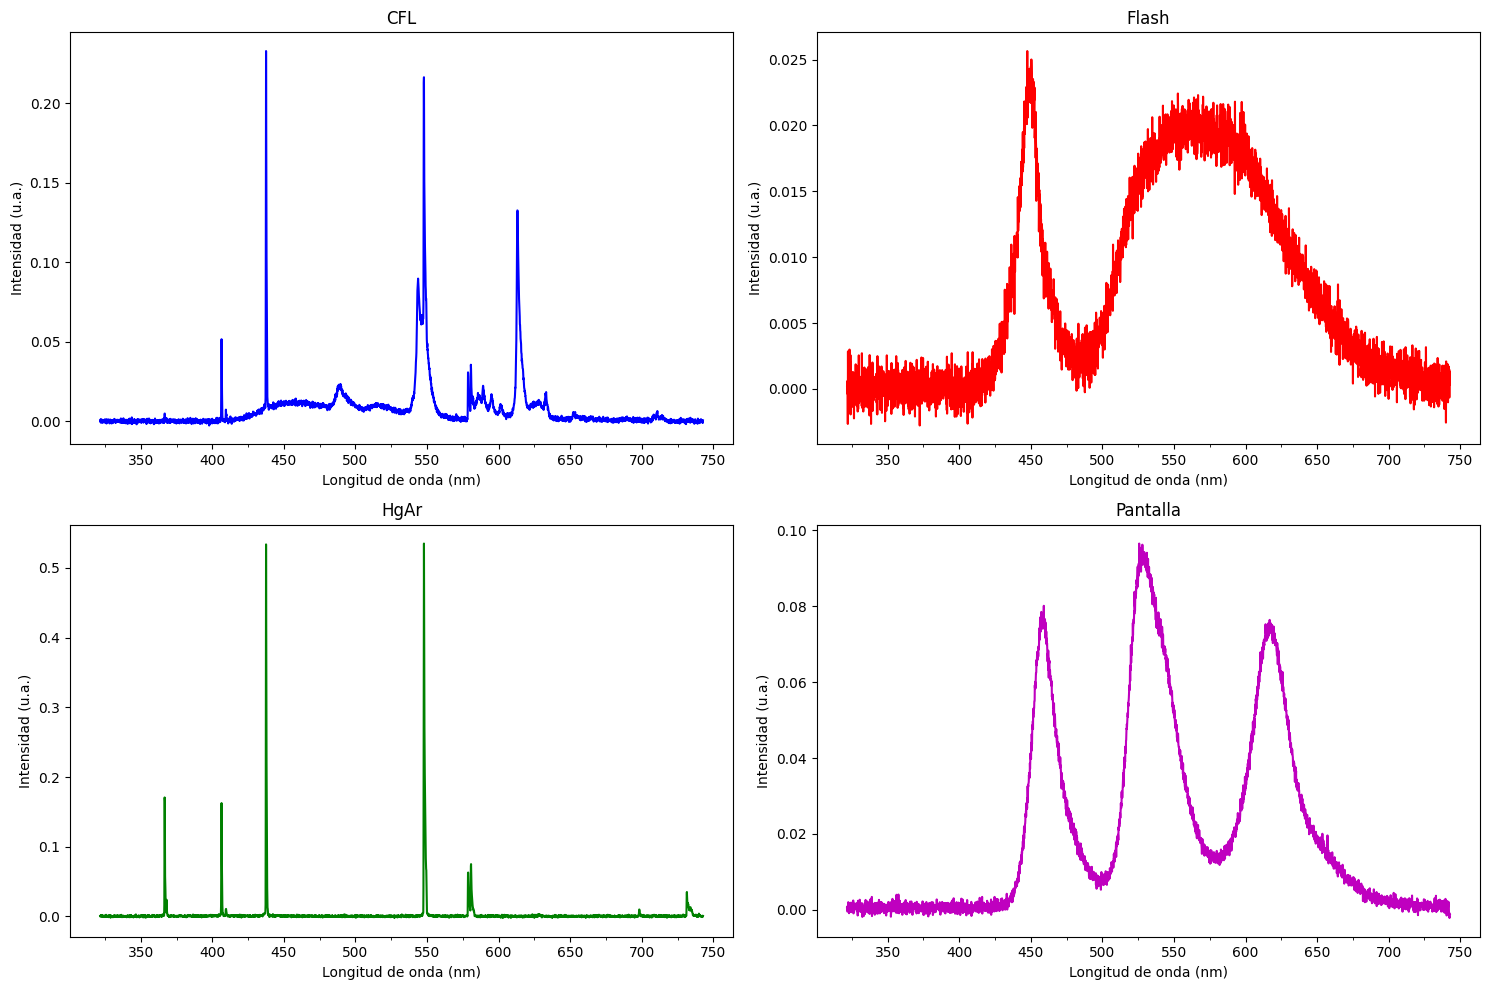

In [47]:
# Finalmente graficamas los datos de cfl, flash, hgar y pantalla por separado en un arrary de 2x2
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(cfl[:,0], cfl[:,1], 'b-')
axs[0, 0].set_title('CFL')
axs[0, 0].set_xlabel('Longitud de onda (nm)')
axs[0, 0].set_ylabel('Intensidad (u.a.)')
axs[0, 0].xaxis.set_major_locator(plt.MultipleLocator(50))
axs[0, 0].xaxis.set_minor_locator(plt.MultipleLocator(25))

axs[0, 1].plot(flash[:,0], flash[:,1], 'r-')
axs[0, 1].set_title('Flash')
axs[0, 1].set_xlabel('Longitud de onda (nm)')
axs[0, 1].set_ylabel('Intensidad (u.a.)')
axs[0, 1].xaxis.set_major_locator(plt.MultipleLocator(50))
axs[0, 1].xaxis.set_minor_locator(plt.MultipleLocator(25))

axs[1, 0].plot(hgar[:,0], hgar[:,1], 'g-')
axs[1, 0].set_title('HgAr')
axs[1, 0].set_xlabel('Longitud de onda (nm)')
axs[1, 0].set_ylabel('Intensidad (u.a.)')
axs[1, 0].xaxis.set_major_locator(plt.MultipleLocator(50))
axs[1, 0].xaxis.set_minor_locator(plt.MultipleLocator(25))

axs[1, 1].plot(panta[:,0], panta[:,1], 'm-')
axs[1, 1].set_title('Pantalla')
axs[1, 1].set_xlabel('Longitud de onda (nm)')
axs[1, 1].set_ylabel('Intensidad (u.a.)')
axs[1, 1].xaxis.set_major_locator(plt.MultipleLocator(50))
axs[1, 1].xaxis.set_minor_locator(plt.MultipleLocator(25))

plt.tight_layout()
plt.show()
